In [1]:
#imports
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_auc_score, f1_score

2024-08-31 22:34:58.435961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-31 22:34:59.551458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def csv_to_numpy_with_names(filename: str):
    data = np.genfromtxt(filename, delimiter=',', dtype=np.float64, names=True)
    names = data.dtype.names
    array = data.view((data.dtype[0], len(data.dtype.names)))
    return array, names

In [3]:
#get data from .csv file
train_data, names = csv_to_numpy_with_names("./dataset/exoTrain.csv")
test_data = csv_to_numpy_with_names("./dataset/exoTest.csv")[0]

In [4]:
#data info
print("Column names:")
print(names)
print()
print("=====================================================================================================================")
print()
print("Data:")
print(train_data)
print()
print("=====================================================================================================================")
print()
print("Train shape:")
print(train_data.shape)
print()
print("Test shape:")
print(test_data.shape)

Column names:
('LABEL', 'FLUX1', 'FLUX2', 'FLUX3', 'FLUX4', 'FLUX5', 'FLUX6', 'FLUX7', 'FLUX8', 'FLUX9', 'FLUX10', 'FLUX11', 'FLUX12', 'FLUX13', 'FLUX14', 'FLUX15', 'FLUX16', 'FLUX17', 'FLUX18', 'FLUX19', 'FLUX20', 'FLUX21', 'FLUX22', 'FLUX23', 'FLUX24', 'FLUX25', 'FLUX26', 'FLUX27', 'FLUX28', 'FLUX29', 'FLUX30', 'FLUX31', 'FLUX32', 'FLUX33', 'FLUX34', 'FLUX35', 'FLUX36', 'FLUX37', 'FLUX38', 'FLUX39', 'FLUX40', 'FLUX41', 'FLUX42', 'FLUX43', 'FLUX44', 'FLUX45', 'FLUX46', 'FLUX47', 'FLUX48', 'FLUX49', 'FLUX50', 'FLUX51', 'FLUX52', 'FLUX53', 'FLUX54', 'FLUX55', 'FLUX56', 'FLUX57', 'FLUX58', 'FLUX59', 'FLUX60', 'FLUX61', 'FLUX62', 'FLUX63', 'FLUX64', 'FLUX65', 'FLUX66', 'FLUX67', 'FLUX68', 'FLUX69', 'FLUX70', 'FLUX71', 'FLUX72', 'FLUX73', 'FLUX74', 'FLUX75', 'FLUX76', 'FLUX77', 'FLUX78', 'FLUX79', 'FLUX80', 'FLUX81', 'FLUX82', 'FLUX83', 'FLUX84', 'FLUX85', 'FLUX86', 'FLUX87', 'FLUX88', 'FLUX89', 'FLUX90', 'FLUX91', 'FLUX92', 'FLUX93', 'FLUX94', 'FLUX95', 'FLUX96', 'FLUX97', 'FLUX98', 'FLUX

In [6]:
#get labels
X_train, y_train = np.delete(train_data, 0, axis=1), np.take(train_data, 0, axis=1).astype(int)
X_test, y_test = np.delete(test_data, 0, axis=1), np.take(test_data, 0, axis=1).astype(int)

In [7]:
#check if dataset is unbalanced...
print(np.unique(y_train, return_counts=True))
#...and it is.... :c

(array([1, 2]), array([5050,   37]))


In [8]:
#indexes of data that detects planets
planet_indexes = np.where(y_train == 2)[0]

print("Planet indexes:", planet_indexes)

Planet indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [9]:
#oversampling
n_over = 5000
X_over = np.array([X_train[ind] for ind in np.random.choice(planet_indexes, n_over)])
y_over = np.array([2 for _ in range(n_over)])

In [10]:
#concatenate original data with oversampled data
X_train, y_train = np.concatenate((X_train, X_over)), np.concatenate((y_train, y_over))

In [11]:
#shuffle new datasets
permutation = np.random.permutation(len(y_train))
X_train, y_train = X_train[permutation], y_train[permutation]

In [12]:
#check if dataset is unbalanced...
print(np.unique(y_train, return_counts=True))
#...and it is not c:

(array([1, 2]), array([5050, 5037]))


In [13]:
def show_charts(X, y, indexes, show_labels=False):
    fig, axes = plt.subplots(1, len(indexes), figsize=(20, 5)) 
    for i in range(len(indexes)):
        index = indexes[i]
        axes[i].plot(X[index])
        axes[i].set_title(f"Label: {y[index]} {"(Planet(s) probably exists)" if y[index] > 0 and show_labels else "(No planets)" if show_labels else ""}")
        # print(f"Label: {y[index]} {"(Planet(s) probably exists)" if y[index] > 0 and show_labels else "(No planets)" if show_labels else ""}")
    plt.show()

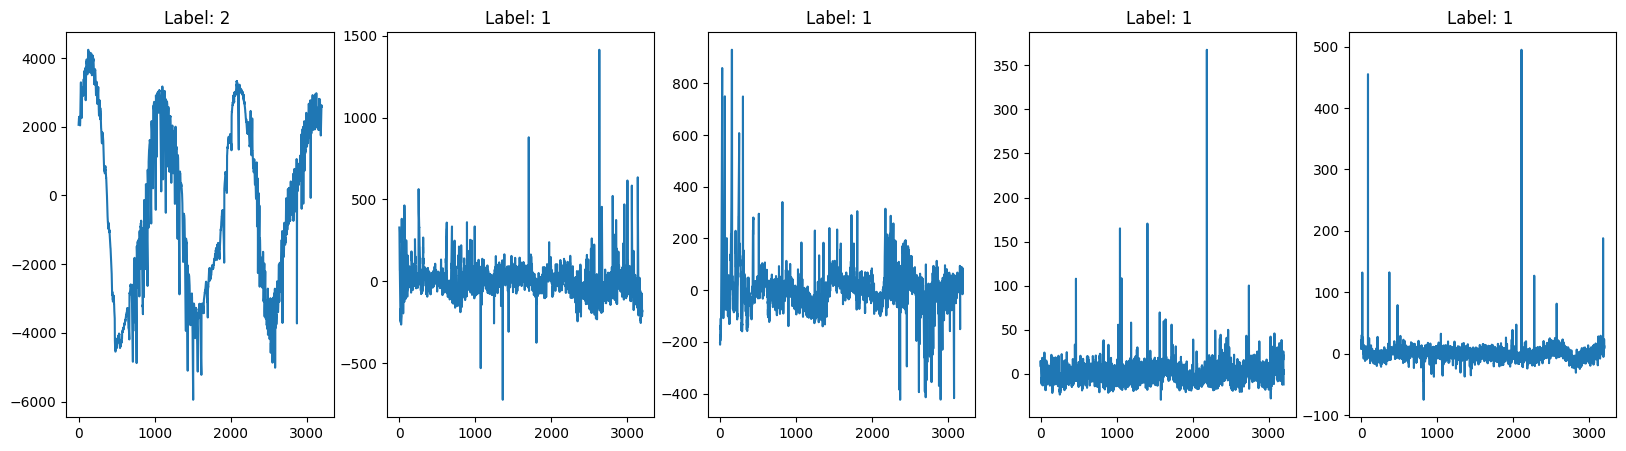

In [14]:
#charts
chart_indexes = [np.random.randint(0, 10000) for _ in range(5)]
show_charts(X_train, y_train, chart_indexes)

In [15]:
def remove_outliers(X_data):
    X = np.empty(X_data.shape)
    for i in range(len(X_data)):
        q1 = np.percentile(X_data[i], 25)
        q3 = np.percentile(X_data[i], 75)
        iqr = q3 - q1

        min_val = q1 - 1.5 * iqr
        max_val = q3 + 1.5 * iqr

        for j in range(1, len(X_data[i])-1):
            if X_data[i][j] < min_val or X_data[i][j] > max_val:
                # X[i][j] = (X_data[i][j-1] + X_data[i][j+1]) / 2
                X[i][j] = X_data[i][j-1]
            else:
                X[i][j] = X_data[i][j]
    return X
    
def normalize_01(data):
    min_val = min(data)
    max_val = max(data)
    d = max_val - min_val
    return (data - min_val) / d

def normalize_X_01(X_data):
    X = np.empty(X_data.shape)
    for i in range(len(X_data)):
        X[i] = normalize_01(X_data[i])
    return X

def prepare_X_data(X_data):
    X = remove_outliers(X_data)
    X = normalize_X_01(X)
    return X
    

In [16]:
#preparing data
X_train, y_train = prepare_X_data(X_train), normalize_01(y_train).astype(int)
X_test, y_test = prepare_X_data(X_test), normalize_01(y_test).astype(int)

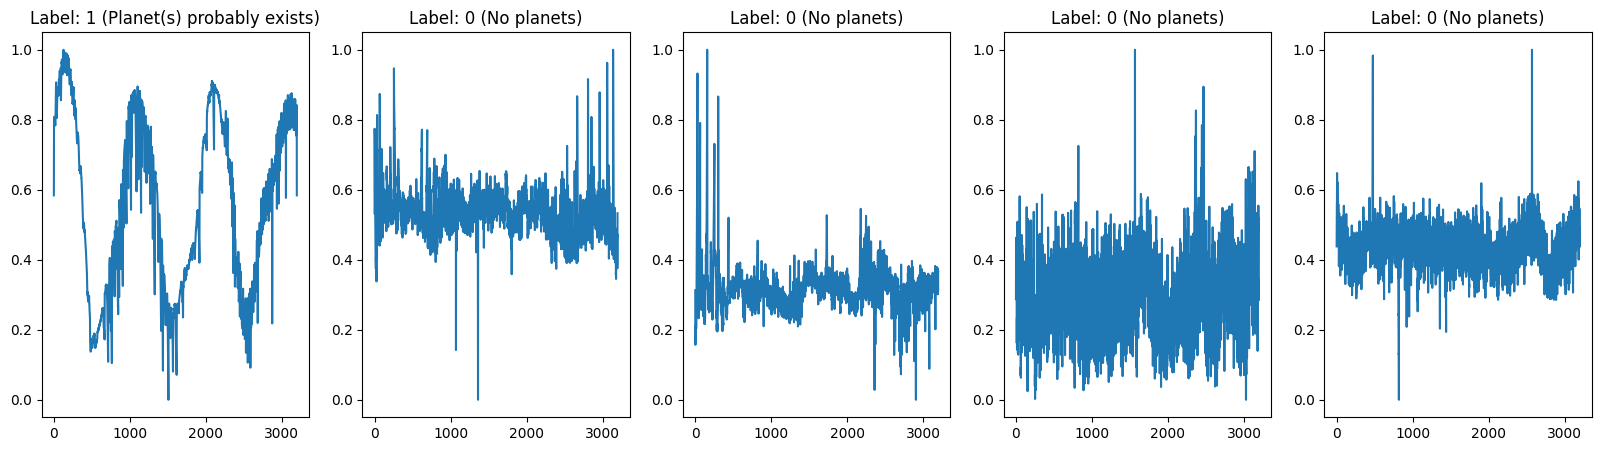

In [17]:
#charts
show_charts(X_train, y_train, chart_indexes, show_labels=True)

In [18]:
#increase data size 2x
# X_train, y_train = np.concatenate((X_train, X_train)), np.concatenate((y_train, y_train))
# print(X_train.shape)

In [19]:
#define model
n1 = 2000
n2 = 500
n3 = 200

model = Sequential()
model.add(Dense(n1, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(n2, activation='relu'))
model.add(Dense(n3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/filipjedrzejewski/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-31 22:37:00.622531: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [20]:
#model compilation
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
             loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),
             metrics=['accuracy', AUC()])

In [21]:
#training
model.fit(X_train, y_train, epochs=10, batch_size=400)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5971 - auc: 0.6300 - loss: 0.1674
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8271 - auc: 0.9160 - loss: 0.1201
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7677 - auc: 0.8516 - loss: 0.1267
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8319 - auc: 0.9202 - loss: 0.0999
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8873 - auc: 0.9551 - loss: 0.0779
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9362 - auc: 0.9841 - loss: 0.0543
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9022 - auc: 0.9601 - loss: 0.0697
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9627 - auc: 0.9896 - loss: 0.0425
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9666 - auc: 0.9917 - loss: 0.0351
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7163 - auc: 0.7710 - loss: 0.3035


In [22]:
#increase test data size - oversampling - for better test quality
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([565,   5]))


In [23]:
n_over = 550
planet_test_indexes = planet_indexes = np.where(y_test == 1)[0]
X_test_over = np.array([X_test[ind] for ind in np.random.choice(planet_test_indexes, n_over)])
y_test_over = np.array([1 for _ in range(n_over)])

In [24]:
X_test, y_test = np.concatenate((X_test, X_test_over)), np.concatenate((y_test, y_test_over))

In [25]:
#tests
loss, accuracy, auc = model.evaluate(X_test, y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("AUC:", auc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4629 - auc: 0.7252 - loss: 0.1839
Loss: 0.16174888610839844
Accuracy: 0.5919643044471741
AUC: 0.7163214683532715


In [26]:
y_pred = model.predict(X_test)
classes_pred = np.array([1 if prediction >= 0.5 else 0 for prediction in y_pred])

print(classes_pred)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[0 1 1 ... 1 1 0]


In [27]:
#confusion matrix
con_matrix = tf.math.confusion_matrix(labels=y_test, predictions=classes_pred)
print(con_matrix)

tf.Tensor(
[[220 345]
 [112 443]], shape=(2, 2), dtype=int32)


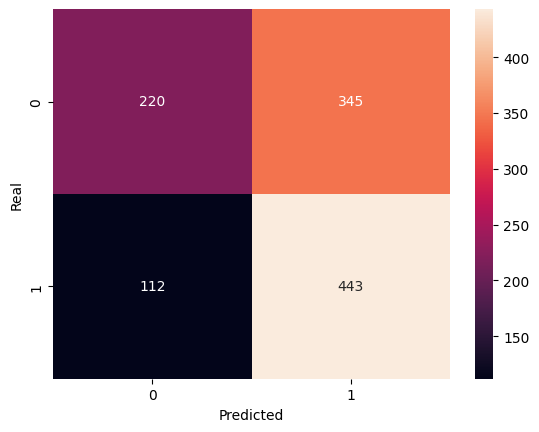

In [28]:
#show confusion matrix
plt.figure()
sns.heatmap(con_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

In [29]:
#AUC
auc = roc_auc_score(y_test, classes_pred)
print("AUC:", auc)

AUC: 0.5937893645858248


In [30]:
#F1
f1 = f1_score(y_test, classes_pred)
print("F1:", f1)

F1: 0.659717051377513
